# 量子相位估计算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_phase_estimation.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/case_library/mindspore_quantum_phase_estimation.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/case_library/quantum_phase_estimation.ipynb)

## 概述

量子相位估计算法(Quantum Phase Estimation Algorithm，简称QPE)，是很多量子算法的关键。假设一个幺正算符 $U$，这个幺正算符作用在其本征态 $|u\rangle$ 上会出现一个相位 $e^{2\pi i \varphi}$，现在我们假设 $U$ 算符的本征值未知，也就是 $\varphi$ 未知，但是 $U$ 算符和本征态 $|u\rangle$ 已知，相位估计算法的作用就是对这个相位 $\varphi$ 进行估计。

![quantum phase estimation](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/quantum_phase_estimation.png)

## 算法解析

量子相位估计算法的实现需要两个寄存器(register)，第一寄存器包含$t$个初始在 $|0\rangle$ 的量子比特，比特数和最后相位估计的结果的精度和算法的成功概率相关；第二个寄存器初始化在幺正算符 $U$ 的本征态 $|u\rangle$ 上。相位估计算法主要分为三步：

### 步骤一

对第一寄存器的所有量子比特进行 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门操作，对第二寄存器连续进行 `控制U` 门操作，其中 $U$ 门的幂次依次为 $2^0, 2^1,...,2^{t-1}$，控制比特依次为 $q_{t-1}, q_{t-2},..., q_{1}, q_{0}$。这时第一寄存器中的态就会变为

$$
|\psi_1\rangle=\frac{1}{2^{t/2}}\left(|0\rangle+e^{i2\pi 2^{t-1}\varphi}|1\rangle\right)\left(|0\rangle+e^{i2\pi2^{t-2}\varphi}|1\rangle\right)...\left(|0\rangle+e^{i2\pi 2^{0}\varphi}|1\rangle\right) = \frac{1}{2^{t/2}}\sum_{k=0}^{2^t-1}e^{i2\pi\varphi k}|k\rangle
$$

其中$k$为直积态的十进制表示，比如 $k=0$ 表示第一寄存器中t个比特全部在基态 $|00...00\rangle$,  $k=2$ 表示 $|00...10\rangle$，以此类推。

### 步骤二

对第一寄存器的进行量子傅里叶变换的逆变换(Inverse Quantum Fourier Transform)，在线路中表示成 $QFT^\dagger$, 对 $|\psi_1\rangle$ 进行逆量子傅里叶变换可得 $|\psi_2\rangle$

$$
|\psi_2\rangle=QFT^\dagger|\psi_1\rangle =\frac{1}{2^t}\sum_{x=0}^{2^t-1}a_x|x\rangle
$$

其中

$$
a_x=\sum_{k=0}^{2^t-1}e^{2\pi i k(\varphi-x/2^t)}
$$

为本征基矢 $|x\rangle$ ($x=0.1,...,2^t$) 对应的概率幅 。由上式可得，当 $2^t\varphi$ 为整数，且满足 $x=2^t\varphi$ 时，概率幅取最大值1，此时第一寄存器的末态可以精确反映 $\varphi$；当 $2^t\varphi$ 不是整数时，$x$ 为 $\varphi$ 的估计，且$t$越大，估计精度越高。

### 步骤三

对第一寄存器的量子比特进行测量，得到第一寄存器的末态 $f=\sum_{x}^{2^t-1}a_x|x\rangle$, $x=0,1,...,2^t$，从中找到最大的振幅 $a_{max}$，其对应的本征基矢 $|x\rangle$ 中的 $x$ 再除以 $2^t$ 即为相位的估计值。

## QPE代码实现

下面用一个实例来演示如何在MindSpore Quantum实现量子相位估计算法，选择 [T](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.TGate.html) 门作为进行估计的幺正算符，由定义

$$
T|1\rangle=e^{i\pi/4}|1\rangle
$$

可知需要估计的相位角为 $\varphi=\frac{1}{8}$。

现在假设我们不知道 [T](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.TGate.html) 门的相位信息，只知道幺正算符 $U$ 是 [T](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.TGate.html) 门且本征态为 $|1\rangle$ ，接下来我们需要用量子相位估计算法求出其对应的本征值，即需要估计本征值指数上的相位角。

首先导入相关依赖。

In [1]:
from mindquantum.core.gates import T, H, X, Power, BARRIER
from mindquantum.core.circuit import Circuit, UN
from mindquantum.simulator import Simulator
from mindquantum.algorithm.library import qft
import numpy as np

[UN](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.UN.html) 可以指定量子门，目标比特和控制比特，从而在线路中搭建门操作； [Power](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.Power.html) 可以得到指定量子门的指数形式。因为我们已知 [T](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.TGate.html) 门的本征态为 $|1\rangle$，所以第二寄存器只需1个比特，而在第一寄存器中的比特数越多，得到的结果就越准确，在这里我们使用4个比特。

因此我们需要搭建5比特线路， $q_0, q_1, q_2, q_3$ 比特用于估计，属于第一寄存器， $q_4$ 属于第二寄存器用于传入 $T$ 算符的本征态。

利用 [UN](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/circuit/mindquantum.core.circuit.UN.html) 对 $q_0, q_1, q_2, q_3$ 进行 [Hadamard](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.HGate.html) 门操作， 用 [X](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.XGate.html) 门对 $q_4$ 进行翻转，得到 [T](https://www.mindspore.cn/mindquantum/docs/zh-CN/master/core/gates/mindquantum.core.gates.TGate.html) 门的本征态 $|1\rangle$。

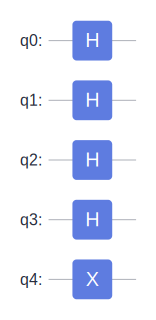

In [2]:
# pylint: disable=W0104
n = 4
circ = Circuit()
circ += UN(H, n) # 对前4个比特作用力H门
circ += X.on(n)  # 对q4作用X门
circ.svg()

以 $q_4$ 为目标比特，添加控制$T^{2^i}$门。

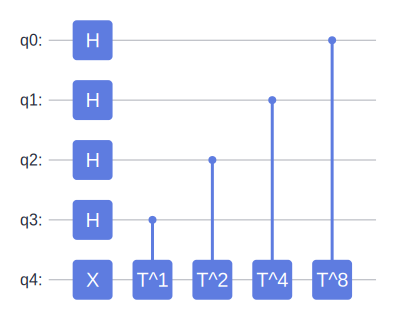

In [3]:
# pylint: disable=W0104
for i in range(n):
    circ += Power(T, 2**i).on(n, n - i - 1) # 添加T^2^i门，其中q4为目标比特，n-i-1为控制比特
circ.svg()

对第一寄存器中的比特进行逆量子傅里叶变换。

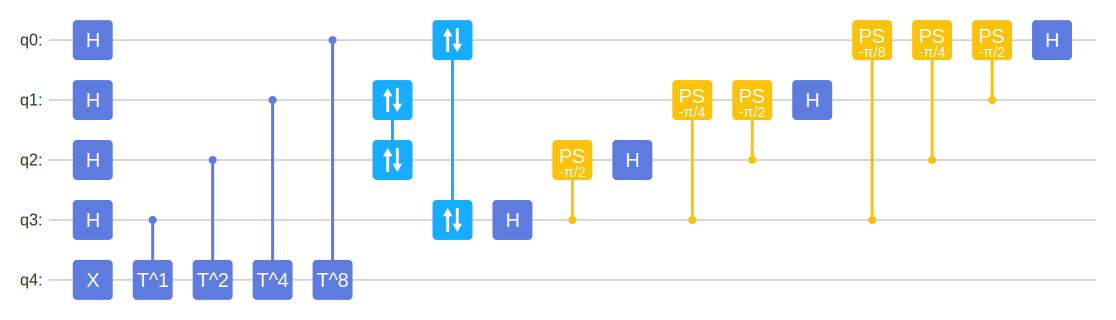

In [4]:
# pylint: disable=W0104
circ += BARRIER
circ += qft(range(n)).hermitian() # 对前4个比特作用量子傅立叶变换的逆变换
circ.svg()

选择后端、传入总比特数创建模拟器，对量子线路进行演化，得到末态。

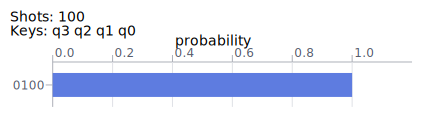

In [5]:
# pylint: disable=W0104
from mindquantum.core.gates import Measure
sim = Simulator('mqvector', circ.n_qubits)                      # 创建模拟器
sim.apply_circuit(circ)                                         # 用模拟器演化线路
qs = sim.get_qs()                                               # 获得演化得到的量子态
res = sim.sampling(UN(Measure(), circ.n_qubits - 1), shots=100) # 在寄存器1中加入测量门并对线路进行100次采样，获得统计结果
res.svg()

需要注意的是，测量结果作为二进制串的读取顺序应为$|q_0q_1q_2q_3\rangle$，因此我们得到寄存器1的测量结果为`0010`，概率幅为1，该末态可以精准地反映相位$\varphi$。但`0010`是二进制结果，因此我们将它转回十进制后再除以$2^n$，就得到了我们最终的估计值：$\varphi=\frac{2}{2^4}=\frac{1}{8}$。

我们也可以通过线路演化得到的量子态 `qs` 找出第一寄存器中振幅最大值 $a_{max}$ 的位置，进而得到其对应的本征基矢 $|x\rangle$ ，其中的 $x$ 再除以 $2^t$ 即为相位的估计值。

In [6]:
index = np.argmax(np.abs(qs))
print(bin(index)[2:])

10100


需要注意的是，`qs` 对应的是整个量子线路的末态，因此得到的 ``index`` 也包含第二寄存器中的比特，不能直接得到第一寄存器末态中 $a_{max}$ 对应的 $|x\rangle$ ，需要将 ``index`` 转成二进制后将 $q4$ 对应的比特位剔除，然后得到的才是第一寄存器的 $|x\rangle$ 。

In [7]:
bit_string = bin(index)[2:].zfill(circ.n_qubits)[1:]        # 将index转换成01串并剔除q4
bit_string = bit_string[::-1]                               # 将比特串顺序调整为q0q1q2q3
print(bit_string)

0010


再将二进制转回十进制，得到我们最终的估计值。

In [8]:
# pylint: disable=W0104
theta_exp = int(bit_string, 2) / 2**n
theta_exp

0.125

可见得到的估计相位和 $\varphi$ 近似相等。

In [9]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sun Dec 31 23:59:31 2023


## 参考文献

[1] Michael A. Nielsen and Isaac L. Chuang. [Quantum computation and quantum information](www.cambridge.org/9781107002173)